In [132]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
# Load data
file_path = "../resources/data/output/customer_churn_prepared.csv"
df = pd.read_csv(file_path)

In [134]:

# Display the first few rows of the dataset
df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn
0,8,0,38,0,4370,5,17,3,1,1,197.640,0
1,0,0,39,0,318,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,2,33,1,1,1,145.805,0


In [135]:
X = df.drop(columns=["churn"])

In [136]:
numeric_features = [
    "call_failure",
    "subscription_length",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "customer_value"
]
categorical_features = ["status", "tariff_plan", "age_group"]

In [137]:
y = df["churn"]

In [138]:
# Plot ROC AUC curve
def plot_roc_auc(y_test, y_prob, label):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [139]:
def train_svm(X, y, num_f, cat_f, kernel='linear', degree=3, label="Model"):
    # 1. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore'), cat_f)
    ])

    # 3. Full Pipeline with SMOTE
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", SVC(kernel=kernel, degree=degree, probability=True, random_state=42))
    ])

    # 4. Train
    pipeline.fit(X_train, y_train)

    # 5. Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 6. Evaluation
    print(f"\nClassification Report ({label} + SMOTE):")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    return pipeline, y_test, y_prob

In [140]:
# Train SVM model for 'linear'
pipeline, y_test_l, y_prob_l = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='linear',
    degree=1,
    label="SVM Linear"
)


Classification Report (SVM Linear + SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       473
           1       0.47      0.80      0.60        80

    accuracy                           0.84       553
   macro avg       0.72      0.82      0.75       553
weighted avg       0.89      0.84      0.86       553

AUC Score: 0.9262


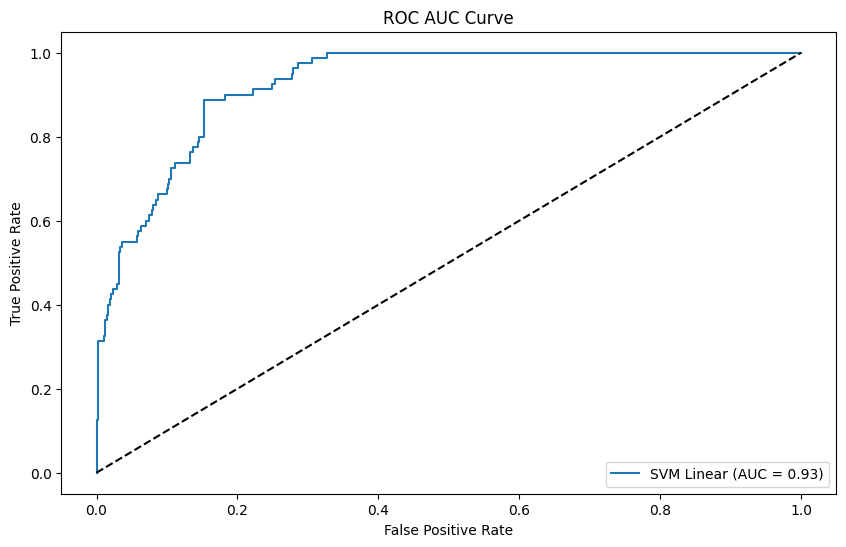

In [141]:
# Plot ROC AUC curve
plot_roc_auc(y_test_l, y_prob_l, label="SVM Linear")

In [142]:
pipeline, y_test_p, y_prob_p = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='poly',
    degree=2,
    label="SVM Linear"
)


Classification Report (SVM Linear + SMOTE):
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       473
           1       0.50      0.89      0.64        80

    accuracy                           0.85       553
   macro avg       0.74      0.87      0.77       553
weighted avg       0.91      0.85      0.87       553

AUC Score: 0.9372


In [143]:
pipeline, y_test_p, y_prob_p = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='poly',
    degree=3,
    label="SVM poly"
)


Classification Report (SVM poly + SMOTE):
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       473
           1       0.54      0.88      0.67        80

    accuracy                           0.87       553
   macro avg       0.76      0.87      0.79       553
weighted avg       0.91      0.87      0.88       553

AUC Score: 0.9596


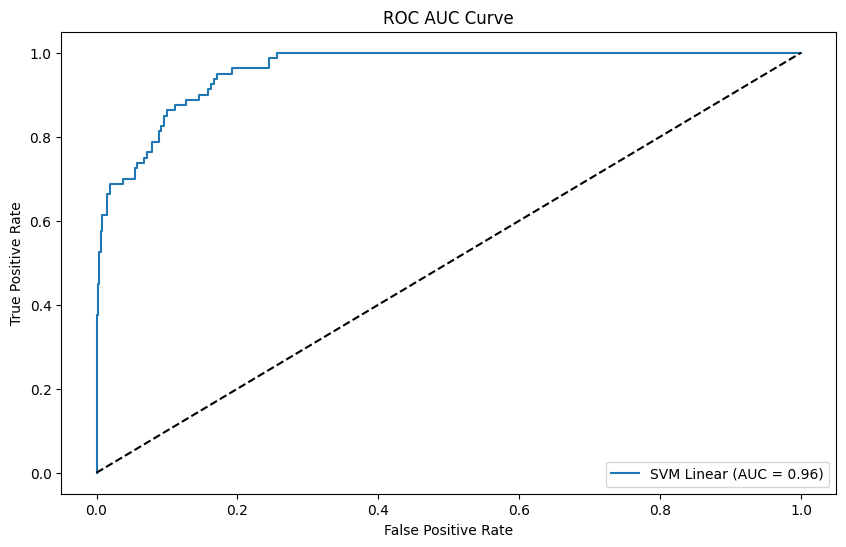

In [144]:
# Plot ROC AUC curve
plot_roc_auc(y_test_p, y_prob_p, label="SVM Linear")

In [145]:
# Train SVM model for 'RBF'
pipeline_rbf, y_test_rbf, y_prob_rbf = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='rbf',
    label="SVM RBF"
)


Classification Report (SVM RBF + SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       473
           1       0.53      0.95      0.68        80

    accuracy                           0.87       553
   macro avg       0.76      0.90      0.80       553
weighted avg       0.92      0.87      0.88       553

AUC Score: 0.9621


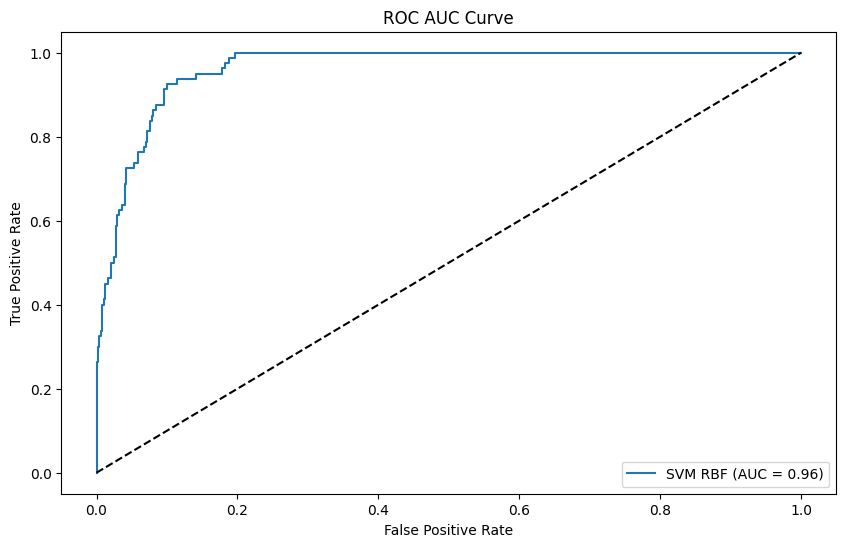

In [146]:
# Plot ROC AUC curve
plot_roc_auc(y_test_rbf, y_prob_rbf, label="SVM RBF")

In [147]:
# Train SVM model for 'RBF'
pipeline_rbf, y_test_rbf, y_prob_rbf = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='rbf',
    label="SVM RBF"
)


Classification Report (SVM RBF + SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       473
           1       0.53      0.95      0.68        80

    accuracy                           0.87       553
   macro avg       0.76      0.90      0.80       553
weighted avg       0.92      0.87      0.88       553

AUC Score: 0.9621


#### **Cross Validation**

In [148]:
from sklearn.model_selection import StratifiedKFold, cross_validate
# Function to evaluate SVM model using Stratified K-Fold CV with SMOTE
def evaluate_svm_pipeline_cv(X, y, num_f, cat_f, model_label="RBF_SVM", k=5, kernel="rbf", degree=3):
    #1. Preprocessing steps: scale numeric and one-hot encode categorical
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_f)
    ])

    # 2. Define pipeline: Preprocessing → SMOTE → SVM classifier
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", SVC(kernel=kernel, degree=degree, probability=True, random_state=42))
    ])

    # 3. Define Stratified K-Fold to preserve churn ratio in each fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # 4. Evaluate the pipeline using cross-validation on AUC, Recall, F1
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=skf,
        scoring=["roc_auc", "recall", "f1"],
        return_train_score=False
    )

    # 5. Print metrics for each fold
    for i in range(k):
        print(f"\n Fold {i+1} | AUC: {scores['test_roc_auc'][i]:.4f} | Recall: {scores['test_recall'][i]:.4f} | F1: {scores['test_f1'][i]:.4f}")

    # 6. Print average performance
    print(f"\n {k}-Fold Cross-Validation Results ({model_label}):")
    print(f"Average AUC:    {np.mean(scores['test_roc_auc']):.4f}")
    print(f"Average Recall: {np.mean(scores['test_recall']):.4f}")
    print(f"Average F1:     {np.mean(scores['test_f1']):.4f}")

    # # 7. Extract feature names
    # ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    # cat_feature_names = ohe.get_feature_names_out(cat_f) if cat_f else []
    # all_feature_names = list(num_f) + list(cat_feature_names)

In [149]:
evaluate_svm_pipeline_cv(
    X,       
    y,                   
    num_f=numeric_features,           
    cat_f=categorical_features,       
    model_label="SVM RBF",        
    k=5,                              
    kernel="rbf",                     # Kernel type: 'rbf', 'linear', or 'poly'
    degree=3                          # Degree for poly kernel (only used if kernel='poly')
)


 Fold 1 | AUC: 0.9691 | Recall: 0.9750 | F1: 0.6812

 Fold 2 | AUC: 0.9614 | Recall: 0.9625 | F1: 0.6937

 Fold 3 | AUC: 0.9561 | Recall: 0.9625 | F1: 0.6581

 Fold 4 | AUC: 0.9708 | Recall: 0.9630 | F1: 0.7059

 Fold 5 | AUC: 0.9710 | Recall: 0.9383 | F1: 0.7238

 5-Fold Cross-Validation Results (SVM RBF):
Average AUC:    0.9657
Average Recall: 0.9602
Average F1:     0.6925


In [150]:
evaluate_svm_pipeline_cv(
    X,       
    y,                   
    num_f=numeric_features,           
    cat_f=categorical_features,       
    model_label="SVM Poly",        
    k=5,                              
    kernel="poly",                    # Kernel type: 'rbf', 'linear', or 'poly'
    degree=3                          # Degree for poly kernel (only used if kernel='poly')
)


 Fold 1 | AUC: 0.9608 | Recall: 0.8750 | F1: 0.6667

 Fold 2 | AUC: 0.9596 | Recall: 0.8875 | F1: 0.6794

 Fold 3 | AUC: 0.9506 | Recall: 0.8875 | F1: 0.6368

 Fold 4 | AUC: 0.9767 | Recall: 0.9383 | F1: 0.7037

 Fold 5 | AUC: 0.9740 | Recall: 0.9259 | F1: 0.7212

 5-Fold Cross-Validation Results (SVM Poly):
Average AUC:    0.9643
Average Recall: 0.9028
Average F1:     0.6815


####  Retrain Final Model on Full Dataset

In [130]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), categorical_features)
])

# Full pipeline with SMOTE and final SVM model
final_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(kernel="rbf", probability=True, random_state=42))
])

# Fit on full dataset (X = features, y = target)
final_pipeline.fit(df.drop(columns="churn"), df["churn"])